## esegui all'inizio

In [8]:
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
#import pymrmr


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
import pymrmr
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

import os

In [7]:

# Percorso del file HDF5 da cui caricare i dati
#load_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/classificator_data.h5"
load_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\classificator_data.h5"

# Inizializza le liste per contenere i dati
loaded_class_images = []
loaded_class_labels = None
loaded_patients = None

# Apre il file HDF5 in modalità lettura
with h5py.File(load_path, 'r') as hf:
    # Itera su tutti i gruppi nel file HDF5
    for group_name in hf.keys():
        # Controlla se il nome del gruppo inizia con "patient_"
        if group_name.startswith("patient_"):
            group = hf[group_name]
            # Carica le immagini dal dataset 'images' all'interno del gruppo
            loaded_class_images.append(np.array(group['images']))
        elif group_name == "labels":
            # Carica le etichette dal dataset 'labels'
            loaded_class_labels = hf['labels'][:]
        elif group_name == "patients":
            # Carica i numeri dei pazienti dal dataset 'patients'
            loaded_patients = hf['patients'][:]

print(f"Dati caricati da {load_path}")
print(f"Numero di pazienti: {len(loaded_class_images)}")
print(f"Esempio di immagini per paziente: {loaded_class_images[0].shape}")


# Carica il file CSV
#file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv"
file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\data_rad_clin_DEF.csv"
data = pd.read_csv(file_path)

# Lista degli ID da escludere
ids_to_exclude = ["patient_TC_19", "patient_TC_40", "patient_TC_88", "patient_TC_150", "patient_TC_193"]

# Filtra il DataFrame per escludere le righe con gli ID specificati
filtered_data = data[~data['IDs_new'].isin(ids_to_exclude)]

# Estrae i valori dalla colonna 'label' del DataFrame filtrato
labels_column = filtered_data['label']

# Converte i valori della colonna 'label' in numeri interi
labels = labels_column.astype(int).tolist()

labels=np.array(labels)
print("Labels:", labels)
print("Number of labels:", len(labels))


# Carica il modello encoder
#encoder = load_model("/Users/alessiamenozzi/Desktop/ThesisPlaques/encoder_models/encoder_model32.h5", compile=False)
#encoder = load_model("/Users/alessiamenozzi/Desktop/encoder64_senzaDense.h5", compile=False)
encoder = load_model("C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\encoder_models\\encoder_model32.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale se necessario (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    #print(features.shape)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

Dati caricati da C:\Users\bsbar\Desktop\Tesi\ThesisPlaques\classificator_data.h5
Numero di pazienti: 124
Esempio di immagini per paziente: (28, 64, 64)
Labels: [0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 1 0 1]
Number of labels: 124


## funzioni 1

In [6]:
## FILE DI FUNZIONI

def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)

    # Print the shape of the combined features array
    #print(f"Shape of combined features array: {all_features_array.shape}")

    # Initialize the new expanded labels and patient IDs vectors
    expanded_labels = []
    expanded_patient_ids = []

    # Assuming labels and loaded_patients are already defined
    # labels: A list of length 124 with labels for each patient
    # loaded_patients: A list of length 124 with IDs for each patient

    # Iterate over the filtered patients and expand the labels and patient IDs
    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])  # Number of images for the current patient
        expanded_labels.extend([labels[i]] * num_images)  # Assign the same label to all images of the patient
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)  # Assign the same patient ID to all images of the patient

    # Convert the lists to NumPy arrays
    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    # Print the shapes of the new arrays to verify
    #print(f"Shape of expanded labels array: {expanded_labels_array.shape}")
    #print(f"Shape of expanded patient IDs array: {expanded_patient_ids_array.shape}")
    return all_features_array, expanded_labels_array, expanded_patient_ids_array


def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    #selected_columns = df.columns[columns]
    return removed_features



def remove_features_from_patients(patients, features_to_remove):
    # Estrai gli indici delle caratteristiche da rimuovere
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    # Rimuovi le caratteristiche corrispondenti dagli array dei pazienti
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


def keep_features_in_patients(patients, features_to_keep):
    # Converti le stringhe degli indici in interi
    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            # Seleziona solo le caratteristiche specificate negli array dei pazienti
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients



def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    # Supponiamo che loaded_patients contenga le etichette dei pazienti

    all_images, _, _= continue_array(z_train, y_train)

    # Creazione del DataFrame con le immagini come righe e le features come colonne
    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    # Visualizzazione del DataFrame
    corr_matrix = df.corr()

    # Se vuoi anche visualizzare la matrice di correlazione con Seaborn
    #plt.figure(figsize=(12, 10))
    #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    #plt.title("Feature Correlation Matrix")
    #plt.show()  
    
    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected



## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    # Fit Lasso regression model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)

    # Get coefficients
    coefficients = lasso.coef_

    # Select features with non-zero coefficients
    selected_features = np.where(coefficients != 0)[0]

    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    data = pd.DataFrame(X, columns=feature_names)
    data['target'] = y
    data.columns = data.columns.astype(str)
    selected_features = pymrmr.mRMR(data, 'MIQ', num_features)
    selected_indices = [data.columns.get_loc(feature) for feature in selected_features]
    # Crea una nuova matrice delle caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_indices]

    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    # Inizializza il classificatore Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Addestra il modello
    rf.fit(X, y)
    # Ottieni l'importanza delle caratteristiche
    feature_importances = rf.feature_importances_
    # Seleziona gli indici delle caratteristiche più importanti
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    """
    Removes the non-selected features from the filtered_patients array.

    Parameters:
    filtered_patients (list of numpy.ndarray): The list containing patients' images' features.
    selected_features (numpy.ndarray): The indices of the selected features.

    Returns:
    list of numpy.ndarray: The new filtered_patients array with only the selected features.
    """
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected

## funzioni 2 per la classificazione

### classificazione

In [69]:
from imblearn.over_sampling import ADASYN
def prob_to_binary(predictions_proba, threshold):
        final_predictionarray=[]          
        ## majority voting
        for p in predictions_proba:
            test_patient_predictions=[]
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > threshold else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions)==0) 
            count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
         
        return final_predictionarray


def classification_method1(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    if(mode == "Val"):
        selected_features = None  # Inizializziamo selected_features per prevenire l'errore UnboundLocalError
        
        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
            elif selector == "logistic": 
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
                return
            
            features_test = filter_patients_features(features_test, selected_features)
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
        number_features = len(selected_features)  # Ora number_features è sempre definito correttamente
        
        if len(X_selected[0]) == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        
        #smote = SMOTE(random_state=42)
        adasyn = ADASYN(random_state=42)

        # Applicare SMOTE al set di dati di addestramento espanso
        #X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
        X_resampled, y_resampled = adasyn.fit_resample(X_selected, y_train_expanded)
        #print(X_selected, " vs Resampled ", X_resampled)
        #print(y_test, "vs resempled " , y_resampled)
        #classifier.fit(X_selected, y_train_expanded)
        classifier.fit(X_resampled, y_resampled)
   
    if (mode == "Test"):
        features_test = filter_patients_features(features_test, selected_features)
        number_features = len(selected_features)

    ### questo trova le probabilità e fa la media
    temp_array = []
    patient_scores = []

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        for i in range(len(features_test[x])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    #thresholds = np.arange(0.001, 0.501, 0.001)
    #thresholds=[0.5]
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, threshold)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, best_threshold)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    #test_precision = precision_score(y_test, best_prediction)
    #test_recall = recall_score(y_test, best_prediction)
    
    precision, recall, _ = precision_recall_curve(y_test, patient_scores)
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold, number_features, selected_features, classifier



In [70]:
def classification_method2(classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, thresholds):
       
    #smote = SMOTE(random_state=42)
    adasyn = ADASYN(random_state=42)

    X_resampled, y_resampled = adasyn.fit_resample(x_train_expanded, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)
   


    ### questo trova le probabilità e fa la media
    temp_array = []

    for x in range(len(patients_test)):
        patient_predictions = []
        for i in range(len(features_test[x])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            patient_predictions.append(prediction)


        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
 
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    best_threshold = thresholds
    best_prediction=prob_to_binary(temp_array, best_threshold)
    best_f1_score = f1_score(y_test, best_prediction)
    best_precision = precision_score(y_test, best_prediction)
    best_recall = recall_score(y_test, best_prediction)

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy



### best threshold

In [71]:
def find_best_threshold_features(results_rf, selector):
    best_thresholds = []
    best_num_features=[]
    best_alpha=[]

    fold_results = results_rf[selector]
        
        # Inizialmente, tutti gli indici con il massimo F1 score
    best_f1_indices = np.where(fold_results['f1'] == np.max(fold_results['f1']))[0]
        
    if len(best_f1_indices) > 1:
            # In caso di parità di F1, considera il pr_auc
            max_pr_auc = max(fold_results['pr_auc'][j] for j in best_f1_indices)
            best_f1_indices = [j for j in best_f1_indices if fold_results['pr_auc'][j] == max_pr_auc]
            # In caso di ulteriore parità, considera l'accuracy
            if len(best_f1_indices)!=1:
                max_accuracy = max(fold_results['accuracy'][j] for j in best_f1_indices)
                best_f1_indices = [j for j in best_f1_indices if fold_results['accuracy'][j] == max_accuracy]
                if len(best_f1_indices)!=1:
                    max_roc_auc = max(fold_results['roc_auc'][j] for j in best_f1_indices)
                    best_f1_indices = [j for j in best_f1_indices if fold_results['roc_auc'][j] == max_roc_auc]
                    #best_f1_indices= best_f1_indices[0]
           
    best_index = best_f1_indices[0]


    # Ottieni l'indice finale del miglior F1 score
    best_threshold=fold_results['best_threshold'][best_index]

    if selector == 'lasso':
        mean_param=fold_results['alpha'][best_index]
    else:
        mean_param=fold_results['num_features'][best_index]



    return best_threshold, mean_param


### plot results

In [72]:

# Supponiamo che tu abbia un elenco di colori predefiniti per i fold
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Supponiamo che results_rf sia un dizionario di dizionari dove:
# results_rf[i][selector] contiene i dati per il fold i e il selettore selector.
# results_test_rf contiene i dati per il set di test finale per ogni selector.

def plot_results(results_rf, results_test_rf, selector):

    # Plotta i risultati per PR AUC
    if selector == 'lasso':
        
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['alpha'], fold_results['pr_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['alpha'], results_test_rf[selector]['pr_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Alpha Values')
        plt.ylabel('AUC')
        plt.title(f'Alpha Values vs PR AUC for {selector} selector')
        plt.xscale('log')
        plt.legend()
        plt.show()

        # Plotta i risultati per ROC AUC
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['alpha'], fold_results['roc_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['alpha'], results_test_rf[selector]['roc_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Alpha Values')
        plt.ylabel('AUC')
        plt.title(f'Alpha Values vs ROC AUC for {selector} selector')
        plt.xscale('log')
        plt.legend()
        plt.show()


    else:
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['num_features'], fold_results['pr_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['num_features'], results_test_rf[selector]['pr_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Number of Features')
        plt.ylabel('AUC')
        plt.title(f'Number of Features vs PR AUC for {selector} selector')
        plt.xscale('linear')
        plt.legend()
        plt.show()

        # Plotta i risultati per ROC AUC
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['num_features'], fold_results['roc_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['num_features'], results_test_rf[selector]['roc_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Number of Features')
        plt.ylabel('AUC')
        plt.title(f'Number of Features vs ROC AUC for {selector} selector')
        plt.xscale('linear')
        plt.legend()
        plt.show()




## codice con split e cross val

In [9]:
#patients_train, patients_test, y_train, y_test, features_train, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=True, stratify=labels, random_state=46)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)
#patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=1)
patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=False, random_state=1)

print(patients_train.shape)
print(patients_train)
print(patients_test)
print(len(features_train))
print(len(features_train[0][0]))
print(len(features_train[1]))
print(len(features_train[2]))
print(patients_test.shape)




alpha_values = np.linspace(0, 0.006, 30).tolist()

selectors=['rf', 'logistic', 'lasso', 'mrmr']
#selectors=['rf', 'lasso', 'logistic']
classifiers=['RandomForest', 'Logistic', 'XgBoost', 'MLP', 'SVM']





(69,)
[  5  12  15  16  17  22  23  24  25  26  27  29  30  31  33  35  36  38
  39  41  42  43  44  46  47  48  50  52  53  54  56  57  58  59  60  61
  62  64  65  68  69  70  71  74  75  76  78  79  81  82  84  85  86  87
  89  90  91  92  94  95  96  98 100 101 102 103 104 105 106]
[147 149 153 155 158 159 161 163 166 168 169 170 171 175 176 178 182 183
 188 189 190 197 199 200 205]
69
32
22
48
(25,)


## LOOP con tutti i selector e classificatori

In [84]:

results_test=[{} for _ in range(len(classifiers))]
results_val = [{} for _ in range(len(classifiers))]
i=0
for classifier in classifiers:
    print("Starting with classifier:", classifier)
    for selector in selectors: 
        print("Doing with selector:", selector)
        results_test[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }
        results_val[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }


        features=perform_correlation(features_train, y_train, 32, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        print(len(x_train_expanded[0]))

        if selector == 'lasso':
                for alpha in alpha_values:
                        print("sto facendo alpha:",alpha)

                        if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        if(classifier=='Logistic'):
                             classi = LogisticRegression()
                        if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                        if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                        if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                        
                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, classifier= classification_method1(
                            selector, alpha, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, 0
                        )

                        if(best_f1_score==0 and best_precision==0 and best_recall==0):
                            break
                    
                        results_val[i][selector]['alpha'].append(alpha)
                        results_val[i][selector]['selected_features'].append(selected_features)
                        results_val[i][selector]['num_features'].append(number_features)
                        results_val[i][selector]['pr_auc'].append(pr_auc)
                        results_val[i][selector]['best_precision'].append(best_precision)
                        results_val[i][selector]['best_recall'].append(best_recall)
                        results_val[i][selector]['roc_auc'].append(roc_auc)
                        results_val[i][selector]['f1'].append(best_f1_score)
                        results_val[i][selector]['accuracy'].append(test_accuracy)
                        results_val[i][selector]['confusion_matrix'].append(conf)
                        results_val[i][selector]['best_threshold'].append(bt)

                        ## classifico il test

                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method1(
                                    selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                                    patients_test, y_test, final_patients_test, 0, bt, "Test", selected_features)
                        
                        
                        results_test[i][selector]['alpha'].append(alpha)
                        results_test[i][selector]['num_features'].append(number_features)
                        results_test[i][selector]['selected_features'].append(selected_features)
                        results_test[i][selector]['pr_auc'].append(pr_auc)
                        results_test[i][selector]['best_precision'].append(best_precision)
                        results_test[i][selector]['best_recall'].append(best_recall)
                        results_test[i][selector]['roc_auc'].append(roc_auc)
                        results_test[i][selector]['f1'].append(best_f1_score)
                        results_test[i][selector]['accuracy'].append(test_accuracy)
                        results_test[i][selector]['confusion_matrix'].append(conf)
                        results_test[i][selector]['best_threshold'].append(bt)
                        
                        
                        # Plot dei risultati per 'lasso'
                        


        else:
                    for t in range(2, len(x_train_expanded[0])+1):
                         
                         print("sto facendo features:",t)
                         
                         if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                         if(classifier=='Logistic'):
                             classi = LogisticRegression()
                         if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                         if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                         if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                         
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, _, selected_features, classifier= classification_method1(
                            selector, 0, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, t
                        )
                         results_val[i][selector]['num_features'].append(t)
                         results_val[i][selector]['pr_auc'].append(pr_auc)
                         results_val[i][selector]['selected_features'].append(selected_features)
                         results_val[i][selector]['best_precision'].append(best_precision)
                         results_val[i][selector]['best_recall'].append(best_recall)
                         results_val[i][selector]['roc_auc'].append(roc_auc)
                         results_val[i][selector]['f1'].append(best_f1_score)
                         results_val[i][selector]['accuracy'].append(test_accuracy)
                         results_val[i][selector]['confusion_matrix'].append(conf)
                         results_val[i][selector]['best_threshold'].append(bt)

                         ## classifico test
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method1(
                                        selector, 0, classifier, x_train_expanded, y_train_expanded, 
                                        patients_test, y_test, final_patients_test, t, bt, "Test", selected_features)
                         
                         results_test[i][selector]['num_features'].append(t)
                         results_test[i][selector]['selected_features'].append(selected_features)
                         results_test[i][selector]['pr_auc'].append(pr_auc)
                         results_test[i][selector]['best_precision'].append(best_precision)
                         results_test[i][selector]['best_recall'].append(best_recall)
                         results_test[i][selector]['roc_auc'].append(roc_auc)
                         results_test[i][selector]['f1'].append(best_f1_score)
                         results_test[i][selector]['accuracy'].append(test_accuracy)
                         results_test[i][selector]['confusion_matrix'].append(conf)
                         results_test[i][selector]['best_threshold'].append(bt)


        #mean_threshold, mean_param  = find_best_threshold_features(results_val[i], selector)
        #print(f"The mean best threshold for {selector} is: {mean_threshold}")
    
        
    i=i+1


 
        #plot_results(results_rf, results_test_rf, selector)

            

Starting with classifier: RandomForest
Doing with selector: rf
30
sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
sto facendo features: 17
sto facendo features: 18
sto facendo features: 19
sto facendo features: 20
sto facendo features: 21
sto facendo features: 22
sto facendo features: 23
sto facendo features: 24
sto facendo features: 25
sto facendo features: 26
sto facendo features: 27
sto facendo features: 28
sto facendo features: 29
sto facendo features: 30
Doing with selector: logistic
30
sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo feat

c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+02, tolerance: 5.470e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+02, tolerance: 5.470e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+02, tolerance: 5.470e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+02, tolerance: 5.470e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\bsbar\anaconda3\envs\iml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+02, tolerance: 5.470e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

In [64]:
val_backup = results_val
test_backup = results_test

## Salvataggio dizionari

In [85]:
import pickle

file_path = "C:\\Users\\bsbar\\Desktop\\results\\results_val32noshuffle.pkl"
#file_path =

# Salvare i risultati in file pickle
with open(file_path, 'wb') as file:
    pickle.dump(results_val, file)

file_path = "C:\\Users\\bsbar\\Desktop\\results\\results_test32noshuffle.pkl"
#file_path =

with open(file_path, 'wb') as file:
    pickle.dump(results_test, file)

print("File Pickle creati con successo.")

File Pickle creati con successo.


In [13]:
import pickle


file_path = "C:\\Users\\bsbar\\Desktop\\results\\results_val32noshuffle.pkl"
#file_path =
with open(file_path, 'rb') as file:
    results_val = pickle.load(file)

file_path = "C:\\Users\\bsbar\\Desktop\\results\\results_test32noshuffle.pkl"
#file_path =
with open(file_path, 'rb') as file:
    results_test = pickle.load(file)

print("File Pickle caricati con successo.")

File Pickle caricati con successo.


## Stampe classifiers e selectors

### ROC

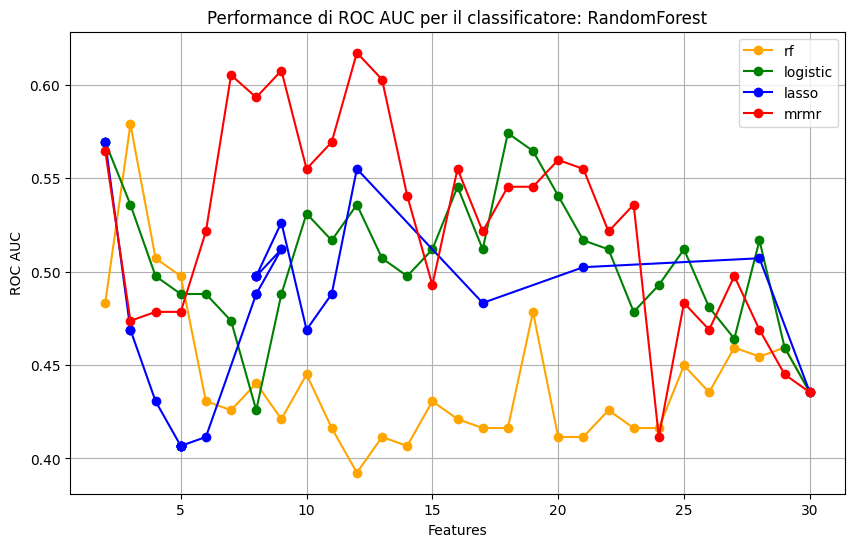

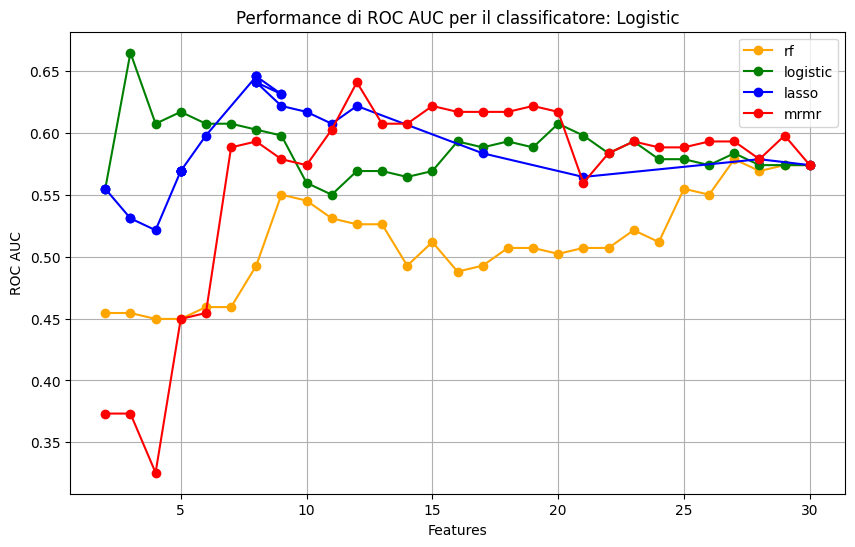

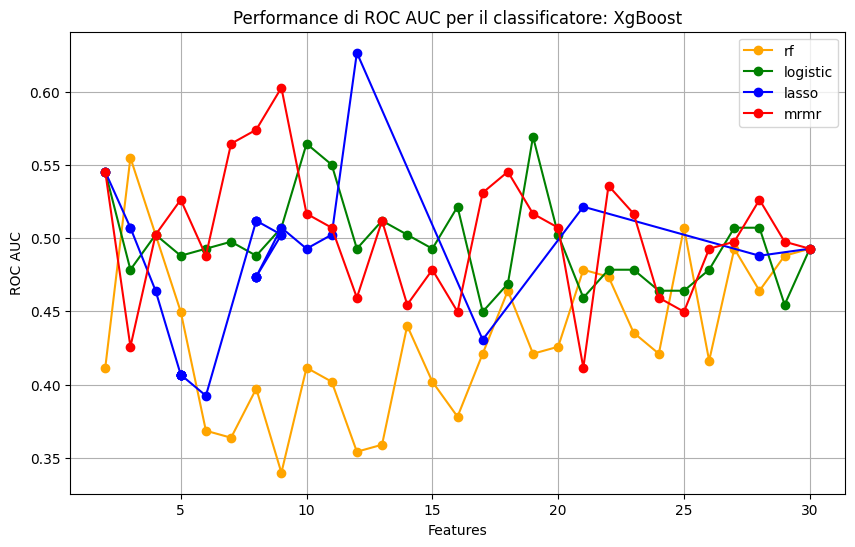

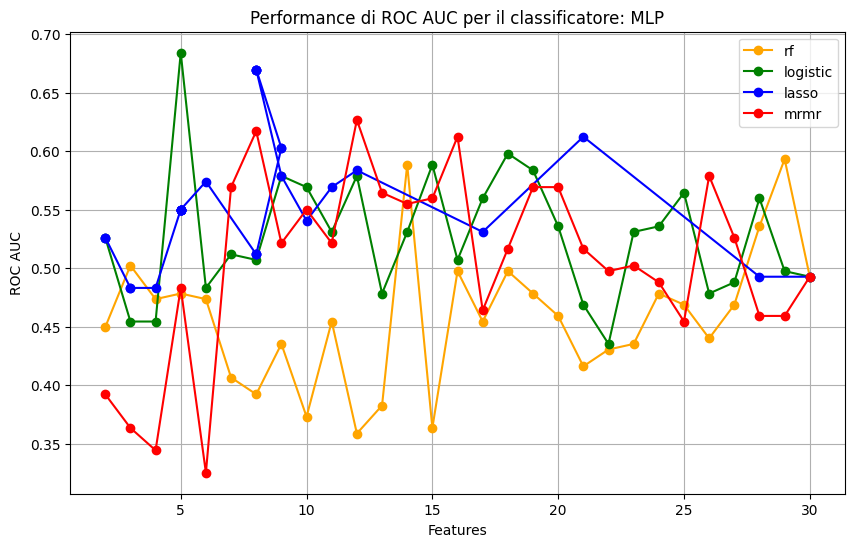

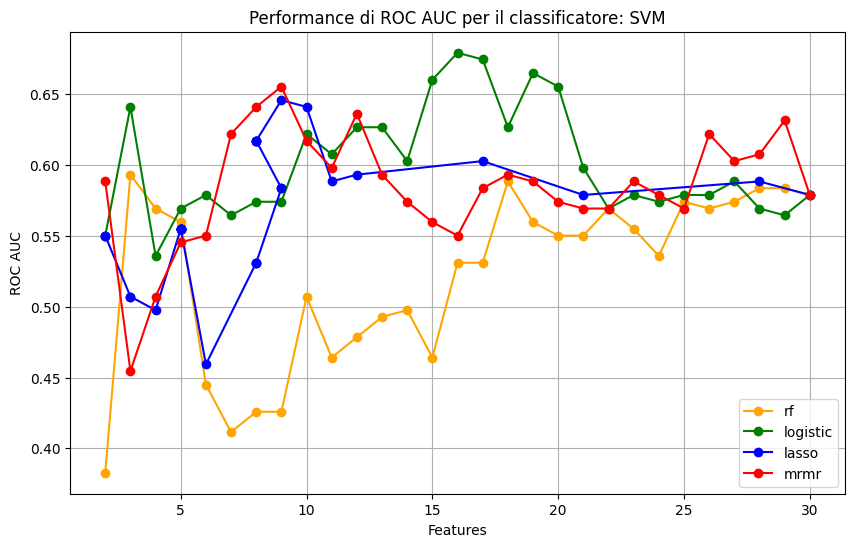

In [14]:
import matplotlib.pyplot as plt

# Definizione di colori diversi per ogni selettore
colors = {
    'lasso': 'blue',
    'logistic': 'green',  # sostituire con il nome effettivo del selettore
    'mrmr': 'red',    # sostituire con il nome effettivo del selettore
    'rf': 'orange'
    # aggiungere altri selettori se necessario
}

# Itera attraverso i classificatori e crea i grafici
for i, classifier in enumerate(classifiers):
    plt.figure(figsize=(10, 6))
    for selector in selectors:
        num_features = results_val[i][selector]['num_features']
        roc_auc = results_val[i][selector]['roc_auc']  # Utilizzo di roc_auc anziché pr_auc

        plt.plot(num_features, roc_auc, marker='o', label=selector, color=colors.get(selector, 'black'))

    plt.title(f'Performance di ROC AUC per il classificatore: {classifier}')
    plt.xlabel('Features')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.grid(True)
    plt.show()


### PR

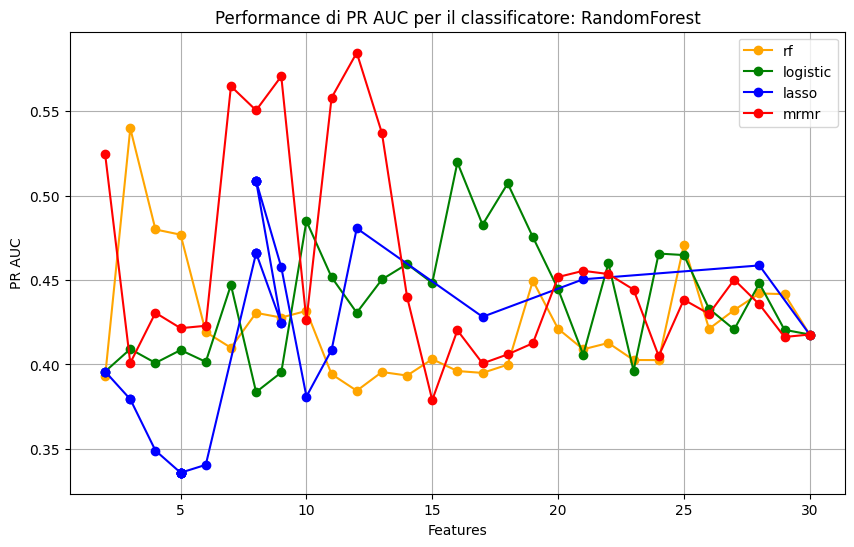

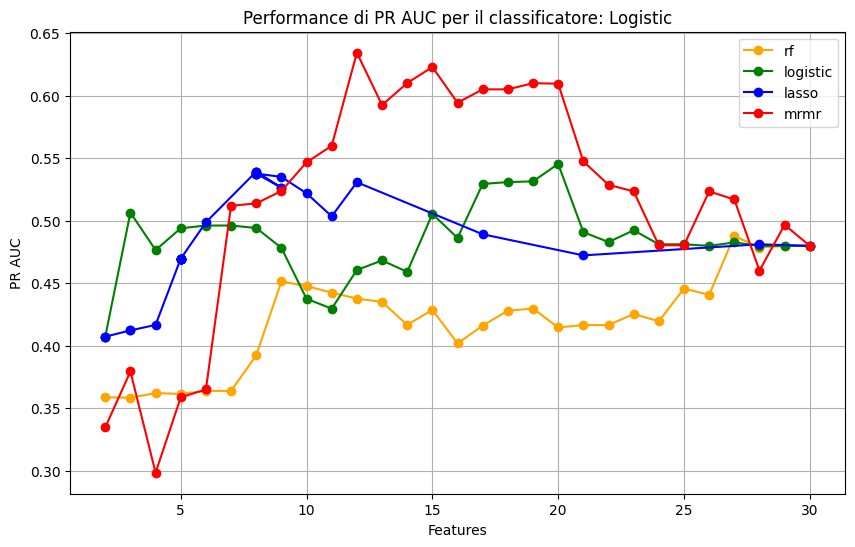

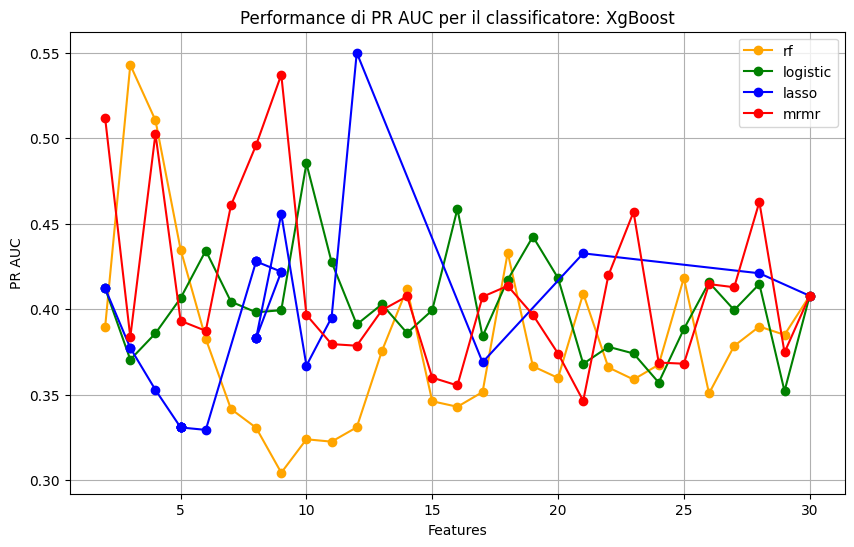

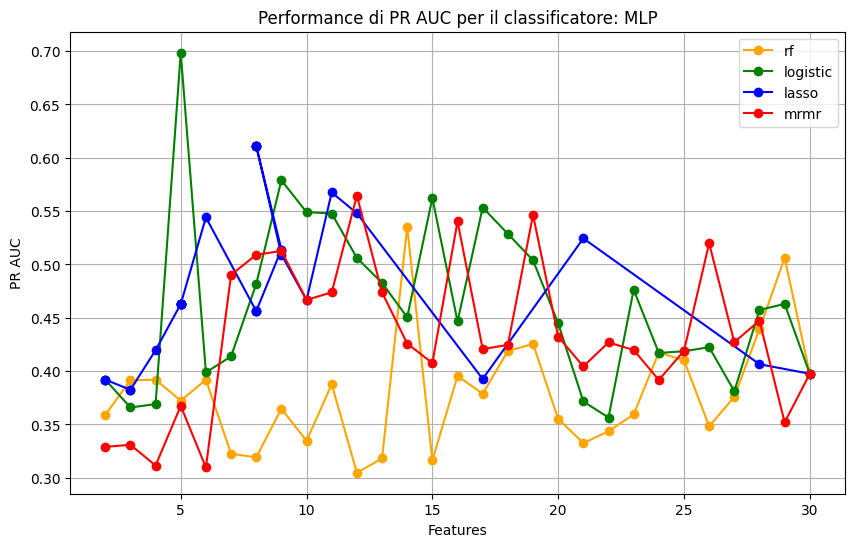

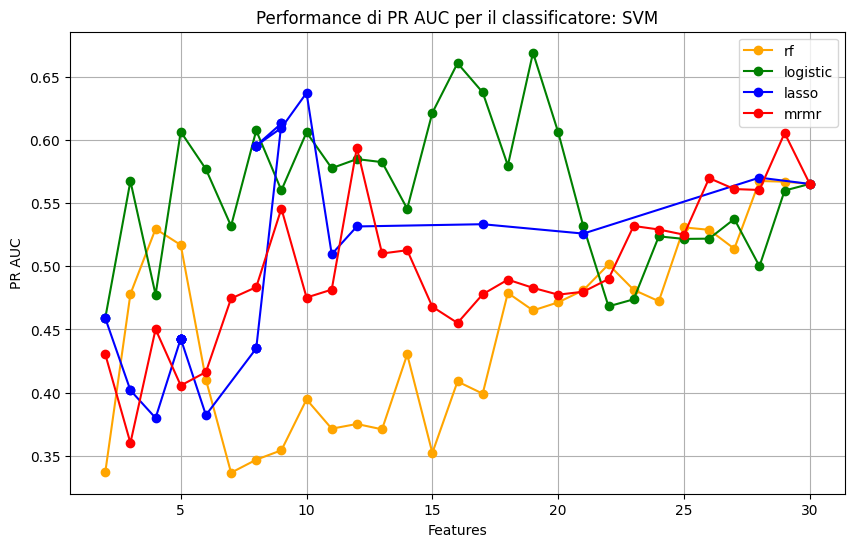

In [87]:
import matplotlib.pyplot as plt

# Definizione di colori diversi per ogni selettore
colors = {
    'lasso': 'blue',
    'logistic': 'green',  # sostituire con il nome effettivo del selettore
    'mrmr': 'red',    # sostituire con il nome effettivo del selettore
    'rf': 'orange'
    # aggiungere altri selettori se necessario
}

# Itera attraverso i classificatori e crea i grafici
for i, classifier in enumerate(classifiers):
    plt.figure(figsize=(10, 6))
    for selector in selectors:
        
        
        
        num_features = results_val[i][selector]['num_features']
        pr_auc = results_val[i][selector]['pr_auc']

        plt.plot(num_features, pr_auc, marker='o', label=selector, color=colors.get(selector, 'black'))

    plt.title(f'Performance di PR AUC per il classificatore: {classifier}')
    plt.xlabel('Features')
    plt.ylabel('PR AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

## Selezione dei migliori casi per ogni classifier rispetto a tutti i selector

In [78]:
# Dizionario per memorizzare i migliori risultati per ogni classificatore
best_results_per_classifier = {classifier: {'selector': None, 'result': None} for classifier in classifiers}

# Funzione per confrontare i risultati e determinare se è migliore
def is_better(result, best_result):
    if 'result' not in best_result or best_result['result'] is None:
        return True
    
    if result['f1'] > best_result['result']['f1']:
        return True
    elif result['f1'] == best_result['result']['f1']:
        if result['pr_auc'] > best_result['result']['pr_auc']:
            return True
        elif result['pr_auc'] == best_result['result']['pr_auc']:
            if result['roc_auc'] > best_result['result']['roc_auc']:
                return True
            elif result['roc_auc'] == best_result['result']['roc_auc']:
                if result['accuracy'] > best_result['result']['accuracy']:
                    return True
                elif result['accuracy'] == best_result['result']['accuracy']:
                    if result['num_features'] > best_result['result']['num_features']:
                        return True
    return False

# Iterazione attraverso i classificatori e i selettori
for i, classifier in enumerate(classifiers):
    for selector in selectors:
        num_results = len(results_val[i][selector]['f1'])
           
        for j in range(num_results):
            current_result = {
                'classifier': classifier,
                'selector': selector,
                'f1': results_val[i][selector]['f1'][j],
                'pr_auc': results_val[i][selector]['pr_auc'][j],
                'roc_auc': results_val[i][selector]['roc_auc'][j],
                'accuracy': results_val[i][selector]['accuracy'][j],
                'num_features': results_val[i][selector]['num_features'][j],
                'confusion_matrix': results_val[i][selector]['confusion_matrix'][j],
                'best_precision': results_val[i][selector]['best_precision'][j],
                'best_recall': results_val[i][selector]['best_recall'][j],
                'roc_auc': results_val[i][selector]['roc_auc'][j],
                'f1': results_val[i][selector]['f1'][j],
                'accuracy': results_val[i][selector]['accuracy'][j],
                'confusion_matrix': results_val[i][selector]['confusion_matrix'][j],
                'best_threshold': results_val[i][selector]['best_threshold'][j],
                'selected_features': results_val[i][selector]['selected_features'][j]
            }
            
            if is_better(current_result, best_results_per_classifier[classifier]):
                best_results_per_classifier[classifier] = {
                    'selector': selector,
                    'result': current_result
                }

classifier_alphas = {}

# Stampare il miglior risultato per ogni classificatore
for classifier, best_result_info in best_results_per_classifier.items():
    best_result = best_result_info['result']
    best_selector = best_result_info['selector']
    
    print(f"Miglior risultato per il classificatore {classifier} (selector {best_selector}):")
    print(f"F1 score: {best_result['f1']}")
    print(f"PR AUC: {best_result['pr_auc']}")
    print(f"ROC AUC: {best_result['roc_auc']}")
    print(f"Accuracy: {best_result['accuracy']}")
    print(f"Numero di features: {best_result['num_features']}")
    print(f"Confusion Matrix:")
    print(best_result['confusion_matrix'])
    print(f"Best Precision: {best_result['best_precision']}")
    print(f"Best Recall: {best_result['best_recall']}")
    print(f"Best Threshold: {best_result['best_threshold']}")
    print(f"Selected Features: {best_result['selected_features']}")


        # Se il selettore è "lasso", recupera e stampa anche il valore di alpha
    if best_selector == 'lasso':
        # Trova l'indice del miglior risultato in results_val per il classificatore e selettore correnti
        idx = results_val[classifiers.index(classifier)][best_selector]['f1'].index(best_result['f1'])
        alpha_opt = results_val[classifiers.index(classifier)][best_selector]['alpha'][idx]
        print(f"Alpha: {alpha_opt}")
    else:
        alpha_opt = 0

    classifier_alphas[classifier] = alpha_opt
    
    print("--------------------")

    print("--------------------")


Miglior risultato per il classificatore RandomForest (selector lasso):
F1 score: 0.8275862068965517
PR AUC: 0.6866089587510915
ROC AUC: 0.7232142857142857
Accuracy: 0.8333333333333334
Numero di features: 8
Confusion Matrix:
[[13  3]
 [ 2 12]]
Best Precision: 0.8
Best Recall: 0.8571428571428571
Best Threshold: 0.49
Selected Features: [ 0  4 35 36 37 38 40 50]
Alpha: 0.002896551724137931
--------------------
--------------------
Miglior risultato per il classificatore Logistic (selector lasso):
F1 score: 0.8125
PR AUC: 0.6764581311393514
ROC AUC: 0.7589285714285714
Accuracy: 0.8
Numero di features: 15
Confusion Matrix:
[[11  5]
 [ 1 13]]
Best Precision: 0.7222222222222222
Best Recall: 0.9285714285714286
Best Threshold: 0.488
Selected Features: [ 0  4  6  9 13 18 22 35 36 37 38 40 43 50 52]
Alpha: 0.0012413793103448274
--------------------
--------------------
Miglior risultato per il classificatore XgBoost (selector lasso):
F1 score: 0.8
PR AUC: 0.8924864351334938
ROC AUC: 0.879464285714

## Estrazione migliore dei migliori

In [79]:
best_overall_result = None
best_overall_classifier = None
best_overall_selector = None

for classifier, best_result_info in best_results_per_classifier.items():
    if 'result' in best_result_info and best_result_info['result'] is not None:
        best_result = best_result_info['result']
        selector = best_result_info['selector']
        
        # Se non abbiamo ancora un miglior risultato globale, lo impostiamo direttamente
        if best_overall_result is None:
            best_overall_result = best_result
            best_overall_classifier = classifier
            best_overall_selector = selector
        else:
            # Altrimenti, confrontiamo i risultati per trovare il miglior classificatore globale
            if (best_result['f1'] > best_overall_result['f1'] or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] > best_overall_result['pr_auc']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
                 best_result['roc_auc'] > best_overall_result['roc_auc']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
                 best_result['roc_auc'] == best_overall_result['roc_auc'] and
                 best_result['accuracy'] > best_overall_result['accuracy']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
                 best_result['roc_auc'] == best_overall_result['roc_auc'] and
                 best_result['accuracy'] == best_overall_result['accuracy'] and
                 best_result['num_features'] > best_overall_result['num_features'])):
                
                best_overall_result = best_result
                best_overall_classifier = classifier
                best_overall_selector = selector

# Salvare i dati desiderati per il migliore dei migliori
if best_overall_result is not None:
    best_threshold_fin = best_overall_result['best_threshold']
    selected_features_fin = best_overall_result['selected_features']
    alpha_fin = classifier_alphas[best_overall_classifier]

    print(f"Miglior classificatore globale: {best_overall_classifier} (selector {best_overall_selector})")
    print(f"Threshold: {best_threshold_fin}")
    print(f"Selected Features: {selected_features_fin}")
    print(f"Alpha: {alpha_fin}")

else:
    print("Nessun miglior risultato globale trovato.")


Miglior classificatore globale: RandomForest (selector lasso)
Threshold: 0.49
Selected Features: [ 0  4 35 36 37 38 40 50]
Alpha: 0.002896551724137931


## Stampa miglior classifier con test

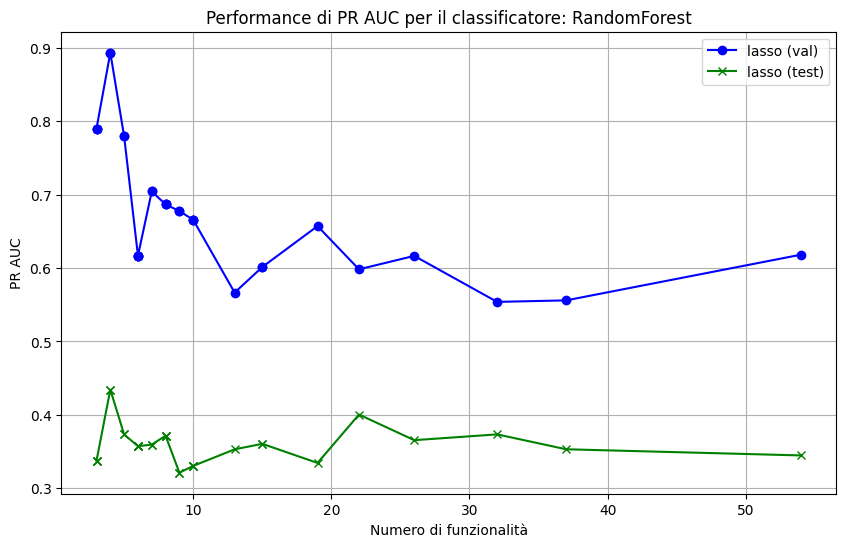

Risultati per 8 funzionalità:
PR AUC: 0.37144001831501827
ROC AUC: 0.5882352941176471
F1: 0.26666666666666666
Precision: 0.2857142857142857
Recall: 0.25
Accuracy: 0.56
Confusion Matrix:
[[12  5]
 [ 6  2]]



In [80]:
import matplotlib.pyplot as plt

# Dati da utilizzare per il grafico
classifier = best_overall_classifier
selector = best_overall_selector


# Recupera i dati di PR AUC e numero di features per results_val e results_test
num_features_val = results_val[classifiers.index(classifier)][selector]['num_features']
pr_auc_val = results_val[classifiers.index(classifier)][selector]['pr_auc']

num_features_test = results_test[classifiers.index(classifier)][selector]['num_features']
pr_auc_test = results_test[classifiers.index(classifier)][selector]['pr_auc']



# Definizione di colori diversi per validazione e test
color_val = 'blue'
color_test = 'green'

plt.figure(figsize=(10, 6))

# Plot per results_val (validazione)
plt.plot(num_features_val, pr_auc_val, marker='o', label=f'{selector} (val)', color=color_val)

# Plot per results_test (test)
plt.plot(num_features_test, pr_auc_test, marker='x', label=f'{selector} (test)', color=color_test)

plt.title(f'Performance di PR AUC per il classificatore: {classifier}')
plt.xlabel('Features')
plt.ylabel('PR AUC')
plt.legend()
plt.grid(True)
plt.show()



specific_num_features = len(selected_features_fin)  # Adatta questo valore al tuo numero specifico di funzionalità

# Cerca l'indice del numero di funzionalità specificato
if specific_num_features in num_features_test:
    index = num_features_test.index(specific_num_features)
    
    # Stampa i risultati per il numero di funzionalità specificato
    print(f"Risultati per {specific_num_features} funzionalità:")
    print(f"PR AUC: {results_test[classifiers.index(classifier)][selector]['pr_auc'][index]}")
    print(f"ROC AUC: {results_test[classifiers.index(classifier)][selector]['roc_auc'][index]}")
    print(f"F1: {results_test[classifiers.index(classifier)][selector]['f1'][index]}")
    print(f"Precision: {results_test[classifiers.index(classifier)][selector]['best_precision'][index]}")
    print(f"Recall: {results_test[classifiers.index(classifier)][selector]['best_recall'][index]}")
    print(f"Accuracy: {results_test[classifiers.index(classifier)][selector]['accuracy'][index]}")
    print(f"Confusion Matrix:\n{results_test[classifiers.index(classifier)][selector]['confusion_matrix'][index]}\n")
else:
    print(f"Numero di funzionalità {specific_num_features} non trovato nei risultati di test.")



## Test con training intero

In [81]:
#patients_train, patients_test, y_train, y_test, features_train, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)

if(best_overall_classifier=='RandomForest'):
         classi = RandomForestClassifier(n_estimators=100, random_state=42)
if(best_overall_classifier=='Logistic'):
                             classi = LogisticRegression()
if(best_overall_classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
if(best_overall_classifier=='XgBoost'):
                             classi = XGBClassifier()
if(best_overall_classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')

#x_train_expanded, y_train_expanded, _= continue_array(features_train1, y_train1)

sf = stringhe_numeri = [str(f) for f in selected_features_fin]

print(sf)

final_patients_train = keep_features_in_patients(features_train1, sf)

x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train1)

features_test_fin = keep_features_in_patients(features_test, sf)

f1_final, precision_final, recall_final, conf_final, accuracy_final= classification_method2(classi, x_train_expanded, y_train_expanded, patients_test, y_test, features_test_fin, best_threshold_fin)

print(f"classifier: {best_overall_classifier}")
print(f"selector: {best_overall_selector}")
print(f"F1 score finale: {f1_final}")
print(f"Precision finale: {precision_final}")
print(f"Recall finale: {recall_final}")
print("Confusion Matrix finale:")
print(conf_final)
print(f"Accuracy finale: {accuracy_final}")
print(f"threshold: {best_threshold_fin}")
print(f"features: {selected_features_fin} e sono {len(selected_features_fin)}")





['0', '4', '35', '36', '37', '38', '40', '50']
classifier: RandomForest
selector: lasso
F1 score finale: 0.42105263157894735
Precision finale: 0.36363636363636365
Recall finale: 0.5
Confusion Matrix finale:
[[10  7]
 [ 4  4]]
Accuracy finale: 0.56
threshold: 0.49
features: [ 0  4 35 36 37 38 40 50] e sono 8
